<p id="part0"></p>
​
<p style="font-family: Arials; line-height: 2; font-size: 44px; font-weight: bold; letter-spacing: 0px; text-align: center; color: #FF8C00">Dicom to png; Here, we crop dicom files,and then turn them to png format</p>
​
<img src="https://th.bing.com/th/id/OIP.zkgR0hxAstCtD3x9REfRvAHaEq?w=262&h=180&c=7&r=0&o=5&dpr=1.8&pid=1.7" width="90%" align="center" hspace="20%" vspace="5%"/>
​
<p style="font-family: Arials; font-size: 40px; font-style: normal; font-weight: bold; letter-spacing: -2px; color: #000000; line-height:2.0">Table of content:</p>
​
<p style="font-family: Arials; font-size: 18px; font-style: normal; font-weight: bold; letter-spacing: 0px; color: #000000; line-height:.5"><a href="#part1" style="color:#000000"> 1- Import Libraries</a></p>

<p style="font-family: Arials; font-size: 18px; font-style: normal; font-weight: bold; letter-spacing: 0px; color: #000000; line-height:.5"><a href="#part2" style="color:#000000"> 2- What is DCIOM file?</a></p>

<p style="text-indent: 1vw; font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 0px; color: #000000; line-height:0.5">
<a href="#part2-1" style="color:#000000">  2-1 Read dicom file</a></p>

<p style="text-indent: 1vw; font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 0px; color: #000000; line-height:0.5">
<a href="#part2-2" style="color:#000000">2-2 Crop dicom file </a></p>

<p style="text-indent: 1vw; font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 0px; color: #000000; line-height:0.5">
<a href="#part2-3" style="color:#000000">2-3 See original and cropped dicom file </a></p>

<p style="text-indent: 1vw; font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 0px; color: #000000; line-height:0.5">
<a href="#part2-4" style="color:#000000">2-4 Turn dicom file to png file </a></p>


<p id="part1"></p>

<p style="font-family: Times New Roman; font-size: 20px; font-style: bold; font-weight: bold; letter-spacing: 0px; color: #0000FF">1- Import libraris<p>
<hr style="height: 1px; border: 1; background-color: #0000FF">

In [1]:
!pip install -qU python-gdcm pydicom pylibjpeg # For better performance in turning dicom to png files

In [2]:
import pandas as pd
import numpy as np
import pydicom
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import cv2
import glob
from joblib import Parallel, delayed
import os,time
import gdcm

<p id="part2"></p>

<p style="font-family: Times New Roman; font-size: 20px; font-style: bold; font-weight: bold; letter-spacing: 0px; color: #0000FF">2- What is DCIOM file?</p>
<hr style="height: 1px; border: 1; background-color: #0000FF">



**DICOM** is an acronym for Digital Imaging and Communications in Medicine. Files in this format are most likely saved with either a DCM or DCM30 (DICOM 3.0) file extension, but some may not have an extension at all.

DICOM is both a communications protocol and a file format, which means it can store medical information, such as ultrasound and MRI images, along with a patient's information, all in one file. The format ensures that all the data stays together, as well as provides the ability to transfer said information between devices that support the DICOM format.

**What package is used for this kind of file in python?**
pydicom is the library you can use in order to open dcm files and manupulate them.Actually, pydicom is a pure Python package for working with DICOM files such as medical images, reports, and radiotherapy objects. For more information , click this [link](https://pydicom.github.io/)

<p id="part2-1"></p>

<p style="font-family: Times New Roman; font-size: 20px; font-style: bold; font-weight: bold; letter-spacing: 0px; color: #0000FF">2-1 Read dicom file</p>
<hr style="height: 1px; border: 1; background-color: #0000FF">

In [3]:
# Before run this code add rsna-breast-cancer dataset
data_set_address= '/kaggle/input/rsna-breast-cancer-detection/'
train_images = sorted(glob.glob(f'{data_set_address}train_images/*/*.dcm'))
# Use glob to work easier on files in directories
number_of_train_images = len(train_images)
print('Number of train_images is :',number_of_train_images) # xepceted:54706

# define a fucntion to read dicom file and return it's pixel
def read_dicom(dicom_file):
    dicom = pydicom.dcmread(dicom_file) # read dciom files
    dicom_pixel = dicom.pixel_array # read the pixel of images

    dicom_pixel = (dicom_pixel - dicom_pixel.min()) / (dicom_pixel.max() - dicom_pixel.min()) # Standardie with transferig to [0,1] space

    if dicom.PhotometricInterpretation == "MONOCHROME1":
        dicom_pixel = 1 - dicom_pixel # a special kind of format in dicom files, you can search it on the net
    
   
    return dicom_pixel

Number of train_images is : 54706


<p id="part2-2"></p>

<p style="font-family: Times New Roman; font-size: 20px; font-style: bold; font-weight: bold; letter-spacing: 0px; color: #0000FF">2-2 Crop dicom file</p>
<hr style="height: 1px; border: 1; background-color: #0000FF">

Define a function to read dicom file and return cropped dicom, using cv2.connectedComponentsWithStats

check this [link](https://stackoverflow.com/questions/35854197/how-to-use-opencvs-connectedcomponentswithstats-in-python) for more detail

In [4]:
def crop_dicom(dicom_file):
    
    result= cv2.connectedComponentsWithStats((dicom_file > 0.005).astype(np.uint8)[:, :], 8, cv2.CV_32S)
    # result has 4 diffrenet outputs. You can see different outputs here.
    # But for reconizing the black color(0) from others(1), we just need result[2] , called stat matrix
    stat_matrix = result[2] # include left, top, width, height, area_size columns
    # the second row shows the boxes of pixels which are different from background.Also, we don't need are_size cloumn. So:
    second_row = stat_matrix[1:, 4].argmax() + 1
    x1, y1, w, h = stat_matrix[second_row][:4]
    x2 = x1 + w
    y2 = y1 + h
    cropped_dicom = dicom_file[y1: y2, x1: x2]
    return cropped_dicom

<p id="part2-3"></p>

<p style="font-family: Times New Roman; font-size: 20px; font-style: bold; font-weight: bold; letter-spacing: 0px; color: #0000FF">2-3 See original and cropped dicom file</p>
<hr style="height: 1px; border: 1; background-color: #0000FF">

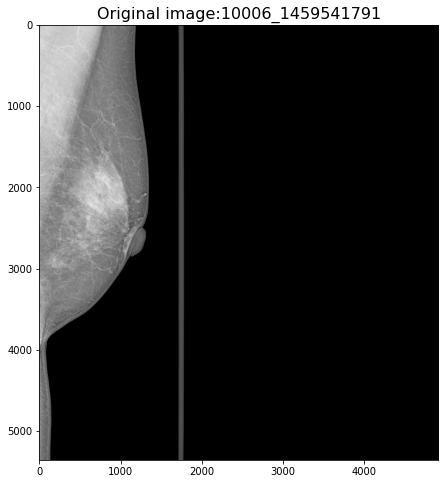

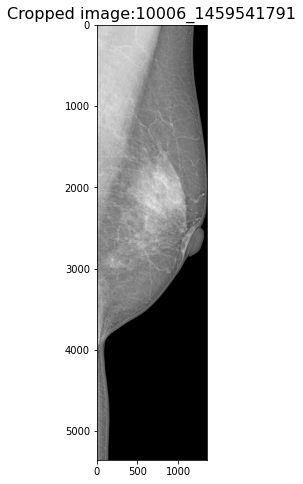

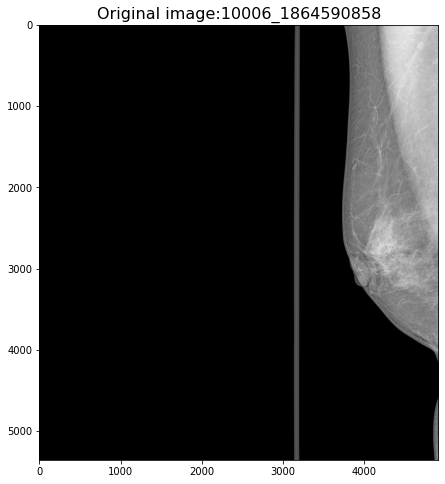

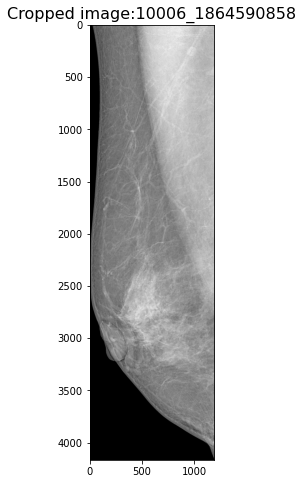

In [5]:
files = train_images[:2]
for file in files:
    patient_id = file.split('/')[-2] # split the patient_id from the whole address
    image_id = file.split('/')[-1][:-4] # split the image_id from the whole address
    

    # Plot Orginial iamge
    plt.figure(figsize=(8,8))
    dicom_pixel = read_dicom(dicom_file=file)
    plt.imshow(dicom_pixel,cmap='gray')
    plt.title(f"Original image:{patient_id}_{image_id}",fontsize=16)
    plt.show()
    
    # Plot cropped image
    plt.figure(figsize=(8,8))
    cropped_iamge = crop_dicom(dicom_file=dicom_pixel)
    plt.imshow(cropped_iamge,cmap='gray')
    plt.title(f"Cropped image:{patient_id}_{image_id}",fontsize=16)
    plt.show()

<p id="part2-4"></p>

<p style="font-family: Times New Roman; font-size: 20px; font-style: bold; font-weight: bold; letter-spacing: 0px; color: #0000FF">2-4 Turn dicom to png file</p>
<hr style="height: 1px; border: 1; background-color: #0000FF">

In [6]:
def dcm_to_png(file,size=512,save_folder="", extension ='png'):
    patient_id = file.split('/')[-2]
    image_id = file.split('/')[-1][:-4]
    dicom_pixel = read_dicom(dicom_file=file) # read dicom image pixels
    cropped_dicom = crop_dicom(dicom_file=dicom_pixel) # crop the dicom image
    resized_img = cv2.resize(cropped_dicom,dsize=(size,size)) # resize it to specific size
    cv2.imwrite(save_folder + f"{patient_id}_{image_id}.{extension}", (resized_img*255).astype(np.uint8))

In [7]:
SAVE_FOLDER = "output/"
os.makedirs(SAVE_FOLDER, exist_ok=True)

In [8]:
# use parallel computing to spend less time on turning dcm to png file
# if you want to test just some files, please use train_images[:10] instead of train_images, including the whole data
start = time.time()
_ = Parallel(n_jobs=4)(
    delayed(dcm_to_png)(file, size=256, save_folder=SAVE_FOLDER)
    for file in tqdm(train_images)  # you can use train_images[:100] for testing
)
stop = time.time()
print('This process took you:',stop-start)
print('Now, you can have access to cropped files wtih png format')

  0%|          | 0/54706 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


This process took you: 27103.709738969803
Now, you can have access to cropped files wtih png format
